# Exercise 2

In [201]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_style("darkgrid")
import numpy as np
import pandas as pd
import math
#import ipympl

## Task 1

### Utility functions

In [202]:
def field_vector(coords:np.array) -> np.array:
    '''
    Takes x, y, z coordinates and returns a field vector
    '''
    x,y,z = coords
    sig: int = 10
    ro: int = 28
    bet: float = 8/3
    return np.array([sig*(y-x), x*(ro-z)-y, x*y-bet*z])

In [203]:
def tent_map_iterator(gt: np.array, a: float) -> np.array:
    '''
    Takes gn and performs tent map iteration for calculating gn+1 error
    '''
    return np.array([1.99999*g + a/2 if g >= -a/2 and g < 0 else -1.99999*g + a/2 for g in gt])

In [204]:
def lorrenz_attractor(Z_t: np.array,dt: float,t: int):
    '''
    Takes initial co-ordinates and simulate a lorrenz attractor with dt time interval and t observations
    '''
    iterations = int(t/dt)
    a = 1/np.sqrt(dt)
    g1 = a*(1/np.sqrt(2) - 1/2)
    g2 = a*(1/np.sqrt(3) - 1/2)
    g3 = a*(1/np.sqrt(5) - 1/2)
    gt = np.array([g1, g2, g3])

    f_z = field_vector(Z_t)
    X_cord = [Z_ini[0],]
    Y_cord = [Z_ini[1],]
    Z_cord = [Z_ini[2],]
    Z_t = np.array(Z_t)
    for i in range(iterations):
        
        # Calculating Z_t+1
        Z_new = Z_t + dt*(f_z+gt)
        
        # Updating gt to gt+1
        gt = tent_map_iterator(gt,a)
        
        # Getting new coordinates and appending to a list
        x,y,z = Z_new
        X_cord.append(x)
        Y_cord.append(y)
        Z_cord.append(z)
        
        # Updating the field vector and the states of the Z_vector
        f_z = field_vector(Z_new)
        Z_t = Z_new
    return [X_cord,Y_cord,Z_cord]

### Plotting the Lorrenz Attractor

In [205]:
### Initializing params
Z_ini: np.array = np.array([-0.587,-0.563,16.870])
dt: float = 0.001
N: int = int(2e5)
tn: int = N*dt # Number of points that we want to generate per dt interval

# Getting all lorrenz attractor coordinates
Z_ref: list = lorrenz_attractor(Z_ini,dt,tn)

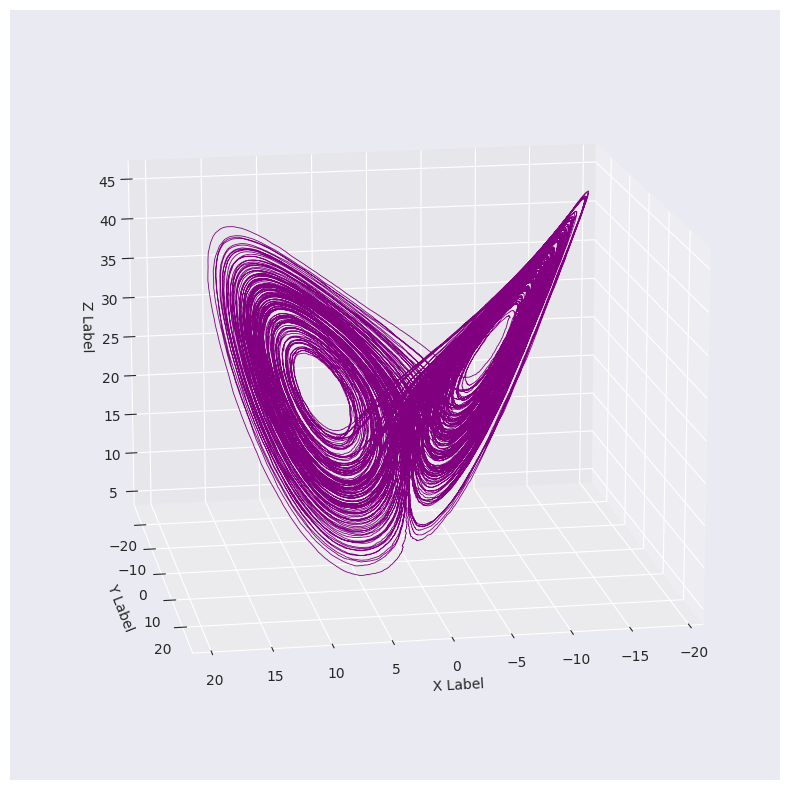

In [206]:
# Generating the plot
x,y,z = Z_ref[0],Z_ref[1],Z_ref[2]
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x,y,z, color = 'purple', lw = 0.6)
ax.view_init(15,80)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

In [216]:
### We are only interested in every 50th point from Z_ref, that becomes our observation. So in all we have 4000 points.
Z_out = []
for i in range(0,len(Z_ref[0]),50):
    Z_out.append(Z_ref[0][i])

In [217]:
ref_trajectory= pd.DataFrame(Z_out).transpose()
ref_trajectory.to_csv("ysd_ref.csv",index = False)

In [218]:
len(Z_out)

4001

## Task 2

In [219]:
# def measurement_error(iterate_cf:int,eta_0: float, a: int,err_ch:int) -> float:
#     '''
#     Takes gn and performs tent map iteration for calculating gn+1 error
#     '''
#     measurement_error: float = 0.0
#     begin = iterate_cf-19
#     end = iterate_cf+1
#     factor = 1.99999 if err_ch == 1 else 2
#     for index in range(begin,end):
#         eta_t = eta_0
#         for i in range(10*index):
#             eta_t = 1.99999*eta_t + a/2 if eta_t >= -a/2 and eta_t < 0 else -1.99999*eta_t + a/2
#         measurement_error+=eta_t
#     return measurement_error

def h_map(Z_ref: np.array) -> list:
    return list(Z_ref.iloc[0,:])

In [256]:
def measurement_errors(eta_0,a,err_ch,N):
    err = [eta_0]
    eta_t = float(eta_0)
    factor = float(2.0) if err_ch == 0 else float(1.99999)
    for i in range(int(N*200)):
        eta_t = factor*eta_t + a/2 if eta_t >= -a/2 and eta_t < 0 else -1*factor*eta_t + a/2
        if i%10 == 0:
            err.append(eta_t)
    summ_err = [eta_0,]
    for i in range(N):
        summ_err.append(sum(err[(i+1)*20-19:(i+1)*20])/20)
        
    return summ_err

In [257]:
def obs_calc(x_ref: list,N: int,err_ch):
    a:float = 4.0
    eta_0:float = a*(1/np.sqrt(2) - 1/2)
    m_e = measurement_errors(eta_0,a,err_ch,N)
    #m_e = [eta_0]
    X_obs = [x_ref[0],]
    for i in range(1,N+1):
        #iterate_cf = i*20
        #m_e.append(1/20*(measurement_error(iterate_cf,eta_0,a,err_ch)))
        # Calculating x_obs
        val = x_ref[i] + m_e[i]
        X_obs.append(val) 
        
    return X_obs,m_e

In [258]:
### Initializing params
Z_ini: np.array = np.array([-0.587,-0.563,16.870])
dt: float = 0.001
t: int = 200

# Getting all lorrenz attractor coordinates
z_ref: list = pd.read_csv("./ysd_ref.csv")

x_ref = h_map(z_ref)

#### First 200 Observations with tentmap having multi_factor = 1.99999

In [259]:
N = 200
t_out = 0.05
observed_x,errors = obs_calc(x_ref,N,1)

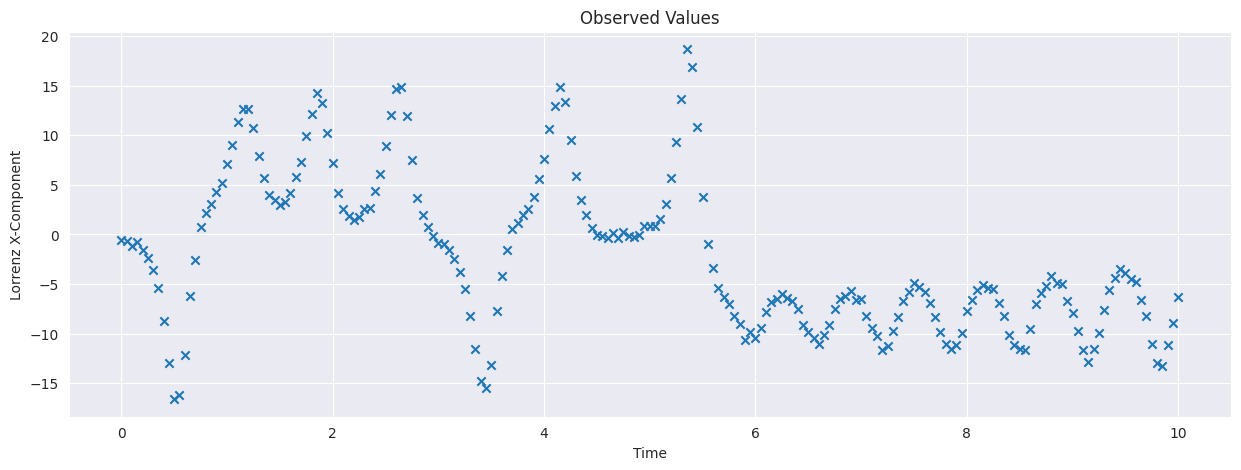

In [260]:
plt.figure(figsize=(15,5))
plt.scatter([i*t_out for i in range(len(observed_x))], observed_x, marker="x")
plt.ylabel("Lorrenz X-Component")
plt.xlabel("Time")
plt.title("Observed Values")
plt.show()

In [261]:
observed_pd = pd.DataFrame(observed_x)
observed_pd.to_csv("ysd_x_TH_obs.csv",index = False)

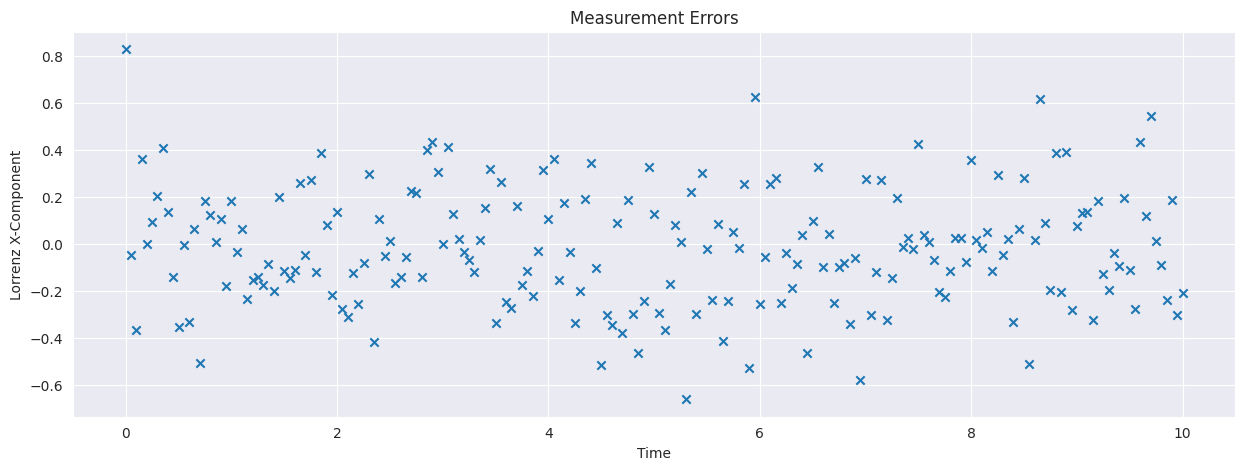

In [262]:
plt.figure(figsize=(15,5))
plt.scatter([i*t_out for i in range(len(errors))], errors, marker="x")
plt.ylabel("Lorrenz X-Component")
plt.xlabel("Time")
plt.title("Measurement Errors")
plt.show()

#### First 200 Observations with tentmap having multi_factor = 2

In [263]:
N = 200
observed_x,errors = obs_calc(x_ref,N,0)

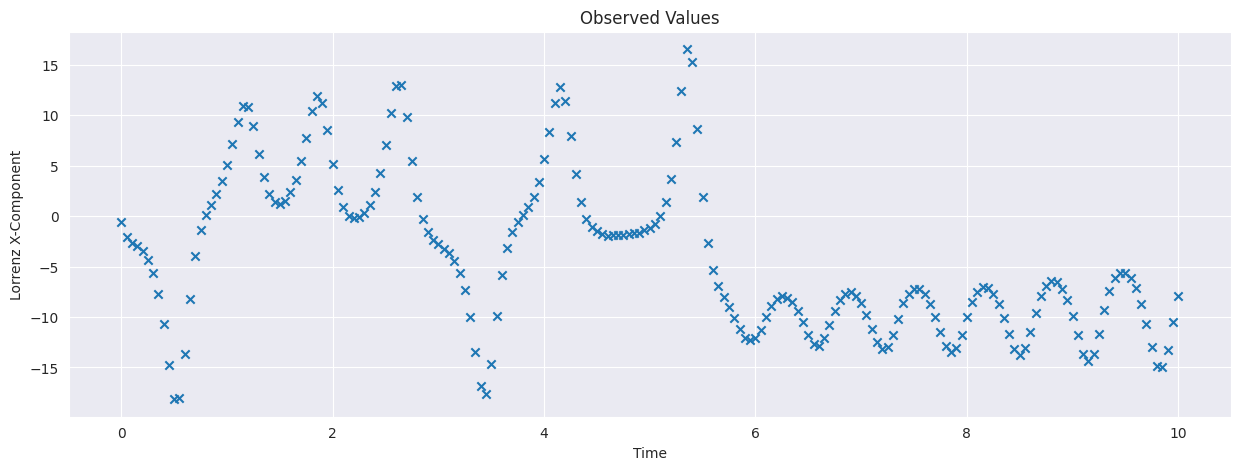

In [264]:
plt.figure(figsize=(15,5))
plt.scatter([i*t_out for i in range(len(observed_x))], observed_x, marker="x")
plt.ylabel("Lorrenz X-Component")
plt.xlabel("Time")
plt.title("Observed Values")
plt.show()

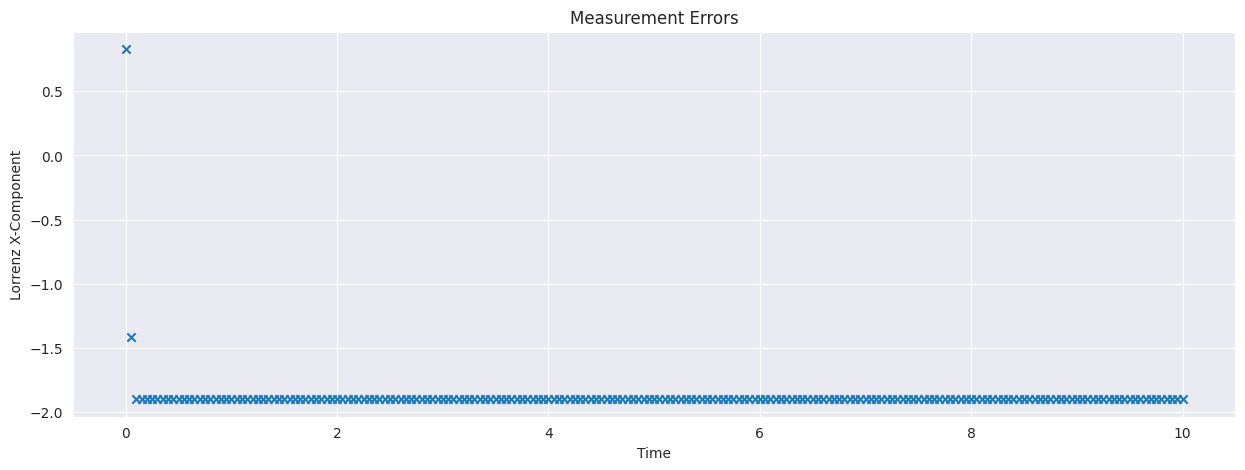

In [265]:
plt.figure(figsize=(15,5))
plt.scatter([i*t_out for i in range(len(errors))], errors, marker="x")
plt.ylabel("Lorrenz X-Component")
plt.xlabel("Time")
plt.title("Measurement Errors")
plt.show()

## Task 3

In [266]:
### Initializing params
Z_ini: np.array = np.array([-0.587,-0.563,16.870])
dt: float = 0.001
t: int = 200
# This gives us 2e5 reference points, using only every 50th ref, leaves us with 4000 points in total 200 time intervals.
# We will be using the first 100 time intervals to interpolate our polynomial and make predictions for the rest interval.
# Thus we will be making predictions from 2001 point onwards.

# Getting all lorrenz attractor coordinates
z_ref: list = pd.read_csv("./ysd_ref.csv")

x_ref = h_map(z_ref)

In [267]:
x = np.array([1,2])
z = np.array([2,3])
def RMSE(predictions: np.array, observations:np.array):
    N = len(predictions)
    return np.sqrt((1/N)*(sum((predictions-observations)**2)))

def predic_calc_1(observed_x: np.array):
    '''
    
    '''
    predictions = np.array([]) # Initializing the preds with null values
    for i in range(2000,4000):
        predictions = np.append(predictions,(2*observed_x[i] - observed_x[i-1]))
    return predictions

def predic_calc_2(observed_x: np.array):
    predictions = np.array([]) # Initializing the preds with null values
    for i in range(2000,4000):
        predictions = np.append(predictions,(3*observed_x[i] - 2*observed_x[i-1]))
    return predictions
#RMSE(x,z)

### RMSE and Visualization prediction when we predict tk+1

In [268]:
N = 4000 #Getting all the observations and errors
observed_x,_ = np.array(obs_calc(x_ref,N,1))
obs_x = observed_x[2001:] #Taking the observations from t = 100 to t = 200
predictions = predic_calc(observed_x)

In [269]:
len(obs_x),len(predictions)

(2000, 2000)

In [270]:
RMSE(predictions,obs_x) #RMSE for the predictions

1.343740906540865

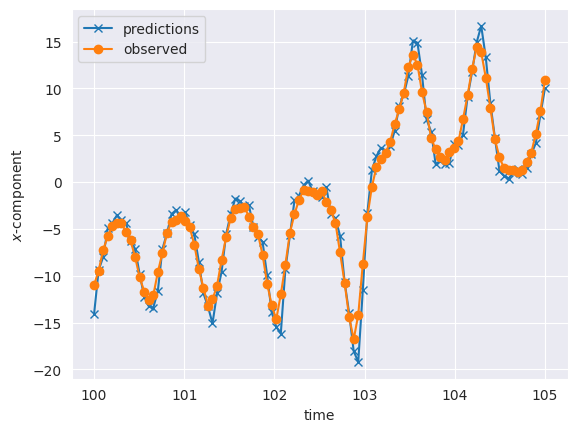

In [271]:
fig1,ax1=plt.subplots()
x1=np.linspace(100,105,100)
ax1.plot(x1,predictions[:100], label='predictions', marker='x')
ax1.plot(x1,obs_x[0:100], label='observed', marker='o')
ax1.legend(loc='best')
ax1.set_xlabel('time')
ax1.set_ylabel('$x$-component')
plt.show()

### RMSE and Visualization prediction when we predict tk+2 instead of tk+1

In [272]:
N = 4000 #Getting all the observations and errors
observed_x,_ = np.array(obs_calc(x_ref,N,1))
obs_x = observed_x[2001:] #Taking the observations from t = 100 to t = 200
predictions = predic_calc_2(observed_x)

In [273]:
len(obs_x),len(predictions)

(2000, 2000)

In [274]:
RMSE(predictions,obs_x) #RMSE for the predictions

2.8774296612586117

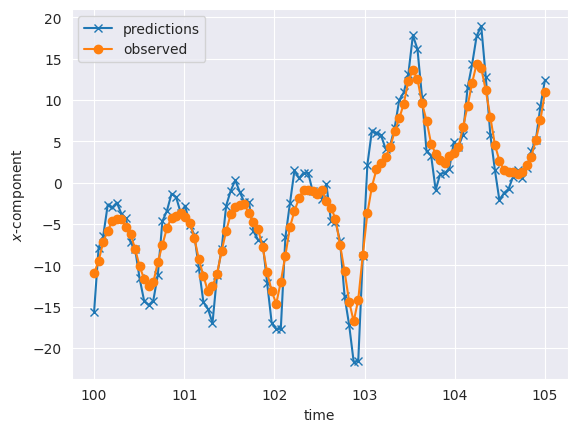

In [275]:
fig1,ax1=plt.subplots()
x1=np.linspace(100,105,100)
ax1.plot(x1,predictions[:100], label='predictions', marker='x')
x1=np.linspace(100,105,100)
ax1.plot(x1,obs_x[0:100], label='observed', marker='o')
ax1.legend(loc='best')
ax1.set_xlabel('time')
ax1.set_ylabel('$x$-component')
plt.show()